In [1]:
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
import shutil
import datetime
import pickle
from collections import Counter
import pydicom
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow.keras.layers as KL
from tensorflow.keras import Model
from tensorflow.keras.mixed_precision import experimental as mixed_precision

import efficientnet.tfkeras as efn # https://github.com/qubvel/efficientnet

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
        
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
#print('Compute dtype: %s' % policy.compute_dtype)
#print('Variable dtype: %s' % policy.variable_dtype)

1 Physical GPUs, 1 Logical GPUs


In [2]:
JPEG_TRAIN = 'data/siim-isic-melanoma-classification/jpeg/train'
JPEG_VAL = 'data/siim-isic-melanoma-classification/jpeg/val'
JPEG_TEST = 'data/siim-isic-melanoma-classification/jpeg/test'
DCM_TRAIN = 'data/siim-isic-melanoma-classification/train'
DCM_VAL = 'data/siim-isic-melanoma-classification/val'
DCM_TEST = 'data/siim-isic-melanoma-classification/test'
CSV_TRAIN = 'data/siim-isic-melanoma-classification/train.csv'
CSV_TEST = 'data/siim-isic-melanoma-classification/test.csv'
SUBMITS_DIR = 'submits/siim-isic-melanoma-classification'

CACHE_FILE = 'cache/siim-isic-melanoma-classification/cache'

WIDTH, HEIGHT = 224, 224
#WIDTH, HEIGHT = 448, 448
#WIDTH, HEIGHT = 896, 896
#WIDTH, HEIGHT = 768, 768
#WIDTH, HEIGHT = 1024, 1024
#WIDTH, HEIGHT = 1120, 1120

# AUGMENTATIONS:
FLIP_ROT = True
BR_SAT_CON = False
CROP = False

BATCH_SIZE = 8

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [3]:
meta = pd.read_csv(CSV_TRAIN)
meta_test = pd.read_csv(CSV_TEST)
meta_test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [4]:
def split_train_val(meta_df, train_path, val_path, val_percent = 0.25, seed = 18, file_ext = 'jpg'):
    n = len(meta_df)
    n_val = int(n * val_percent)
    n_train = n - n_val
    train_val = ['train'] * n_train + ['val'] * n_val
    random.seed(seed)
    random.shuffle(train_val)
    meta_df['train_val'] = train_val
    
    p = pathlib.Path(train_path)
    l = list(p.glob(str('**/*.' + file_ext)))
    if len(l) != n:
        print('Is train/val split already done?')
        return meta_df
    
    i = 0
    for source in l:
        #print(source)
        if meta_df.loc[meta_df['image_name'] == source.stem, 'train_val'].values[0] == 'val':
            #print('val', source.stem)
            dest = pathlib.Path(val_path, source.name)
            #print(dest)
            shutil.move(source, dest)
            i += 1
    
    if i == n_val:
        print(n_val, 'validation images moved to validation directory')
    else:
        print('There is a discrepancy in number of validation images moved')
        print('Images supposed to be moved:', n_val)
        print('Images moved:', i)
    
    return meta_df

In [5]:
#meta = split_train_val(meta, JPEG_TRAIN, JPEG_VAL, file_ext = 'jpg')
meta = split_train_val(meta, DCM_TRAIN, DCM_VAL, file_ext = 'dcm')
meta

Is train/val split already done?


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,train_val
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,train
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,val
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,train
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,train
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,train
...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,train
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,train
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,val
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,train


In [6]:
def move_to_target_subfolders(meta_df, data_path, target_list, file_ext = 'jpg'):
    
    p = pathlib.Path(data_path)
    for target in target_list:
        p_target = p.joinpath(str(target))
        p_target.mkdir(exist_ok = True)
    
    l = list(p.glob(str('**/*.' + file_ext)))
    
    for p_image in l:
        image_name = p_image.stem
        #print(image_name)
        target = meta_df.loc[meta_df['image_name'] == image_name, 'target'].values[0]
        #print(target)
        p_target = p.joinpath(str(target)).joinpath(p_image.name)
        shutil.move(p_image, p_target)
        #print(p_target)
        #break
    print('Images moved to target subfolders')
        
#move_to_target_subfolders(meta, JPEG_TRAIN, [0, 1], file_ext = 'jpg')
#move_to_target_subfolders(meta, JPEG_VAL, [0, 1], file_ext = 'jpg')
#move_to_target_subfolders(meta, DCM_TRAIN, [0, 1], file_ext = 'dcm')
#move_to_target_subfolders(meta, DCM_VAL, [0, 1], file_ext = 'dcm')

In [7]:
ds = pydicom.dcmread(str(DCM_TEST + '/ISIC_0052060.dcm'))
ds['PixelData']
type(ds.pixel_array)
ds.pixel_array.shape
#plt.imshow(ds.pixel_array[:,:,:], cmap = None)

(4000, 6000, 3)

In [8]:
def augment(img, label):
    #if CROP:
    #    crop_factor = tf.random.uniform(shape = (), minval = 1, maxval = 1.5)
    #    #tf.print(crop_factor)
    #    img = preprocess_images(img, int(HEIGHT*crop_factor), int(WIDTH*crop_factor))
    #    img = tf.image.random_crop(img, [HEIGHT, WIDTH, 3])
        
    if FLIP_ROT:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        k = tf.random.uniform(shape = (), minval=0, maxval=4, dtype=tf.int32)
        img = tf.image.rot90(img, k)
        
    if BR_SAT_CON:
        img = tf.image.random_brightness(img, max_delta=63. / 255.)
        img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
        img = tf.image.random_contrast(img, lower=0.2, upper=1.8)
    return img, label

def decode_dcm(img_path):
    img_path = str(img_path.numpy(), 'utf-8')
    ds = pydicom.dcmread(img_path)
    img = ds.pixel_array
    img = pydicom.pixel_data_handlers.util.convert_color_space(img, 'YBR_FULL_422', 'RGB')
    img = tf.convert_to_tensor(img, dtype = tf.uint8)
    return img
    
def process_path(img_path):
    #image_name = tf.strings.split(tf.strings.split(img_path, os.sep)[-1], '.')[0]
    #ext = tf.strings.split(tf.strings.split(img_path, os.sep)[-1], '.')[1]
    #tf.print(image_name, ext)
    train_val_test = tf.strings.split(img_path, os.sep)[2]
    #tf.print(train_val_test)

    if train_val_test != tf.constant('test', dtype = tf.string):
        label = tf.strings.split(img_path, os.sep)[-2]
        label = tf.strings.to_number(label, tf.int32) 
    else:
        label = -1
    
    img = tf.py_function(func = decode_dcm, inp = [img_path], Tout = tf.uint8)
    img.set_shape([None, None, 3])

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [HEIGHT, WIDTH])
        
    return img, label

def dataset_from_image_files(img_path, shuffle_buffer_size, cache = False, ext = 'dcm'):
    train_val_test = img_path.split('/')[2]
    if img_path.split('/')[-1] != train_val_test:
        target = img_path.split('/')[-1]
    else:
        target = None
    
    if train_val_test == 'test':
        ds = tf.data.Dataset.list_files(str(img_path + '*.' + ext), shuffle = False)
    else:
        ds = tf.data.Dataset.list_files(str(img_path + '*.' + ext), shuffle = True)
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    if isinstance(cache, str):
        ds = ds.cache(str(cache + '-' + str(HEIGHT) + 'x' + str(WIDTH)))
    
    if train_val_test != 'test':
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        
    if target == '1' and train_val_test == 'train':
        tf.print('augmenting', img_path)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        
    if target == None:
        ds = ds.batch(BATCH_SIZE)
        
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [19]:
def dataset_combine(img_path, cache, shuffle_buffer_size = 1000):
    ds_0 = dataset_from_image_files(str(img_path + '/0'),
                                    shuffle_buffer_size = shuffle_buffer_size, 
                                    cache = str(cache + '-0'), ext = 'dcm')
    ds_1 = dataset_from_image_files(str(img_path + '/1'), 
                                    shuffle_buffer_size = shuffle_buffer_size, 
                                    cache = str(cache + '-1'), ext = 'dcm')

    w = 0.8
    ds = tf.data.experimental.sample_from_datasets([ds_0, ds_1], weights=[w, 1-w])
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

ds_train = dataset_combine(DCM_TRAIN, cache = str(CACHE_FILE + '-train'), 
                           shuffle_buffer_size = 1000)

ds_val = dataset_from_image_files(DCM_VAL, shuffle_buffer_size = 1000, 
                                  cache = str(CACHE_FILE + '-val'), ext = 'dcm')

ds_test = dataset_from_image_files(DCM_TEST, shuffle_buffer_size = 100, 
                                  cache = str(CACHE_FILE + '-test'), ext = 'dcm')

augmenting data/siim-isic-melanoma-classification/train/1


In [20]:
def show(image, label):
    for i in range(BATCH_SIZE):
        plt.figure()
        plt.imshow(image[i,:,:,:])
        plt.title(str(i) + ' - ' + str(label.numpy()[i]))
        plt.axis('off')

(8,)
(8, 224, 224, 3)


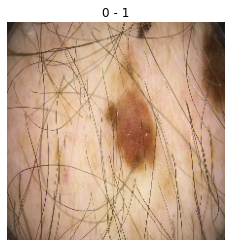

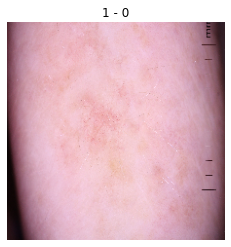

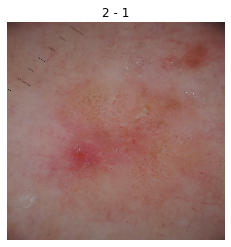

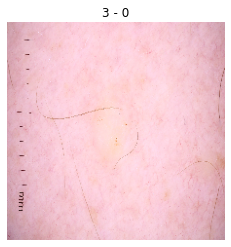

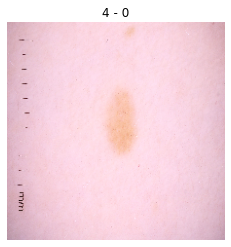

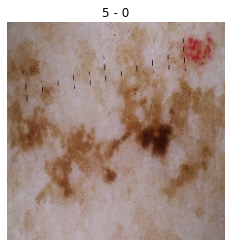

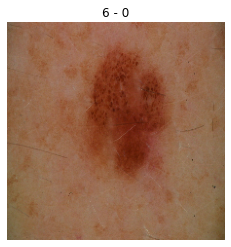

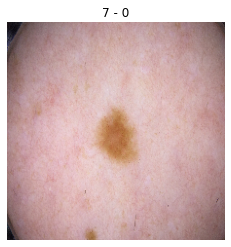

In [22]:
for image, label in ds_train.take(1):
    show(image, label)
    print(label.shape)
    print(image.shape)

In [11]:
i = 0
for image, label in ds_train:
    if i % 10 == 0:
        print(i)
    if i == int(60000/BATCH_SIZE):
        break
    i += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [13]:
i = 0
for image, label in ds_test:
    if i % 10 == 0:
        print(i)
    i += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370


In [ ]:
list(ds_train.as_numpy_iterator())

In [ ]:
def build_resnet50():
    base_model = tf.keras.applications.ResNet50(include_top=True, weights=None, 
                                            input_tensor=None, input_shape=(HEIGHT, WIDTH, 3),
                                            pooling=None)
    #base_model.summary()
    new_output = KL.Dense(1, activation = 'sigmoid', dtype = 'float32')(base_model.layers[-2].output)
    model = Model(base_model.input, new_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=METRICS)
    model.summary()
    return model
#model = build_resnet50()

In [33]:
def build_efficientnet_bX(level = 0, lr = 0.001 ):
    if level == 0:
        base_model = efn.EfficientNetB0(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 1:
        base_model = efn.EfficientNetB1(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 2:
        base_model = efn.EfficientNetB2(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 3:
        base_model = efn.EfficientNetB3(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 4:
        base_model = efn.EfficientNetB4(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 5:
        base_model = efn.EfficientNetB5(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 6:
        base_model = efn.EfficientNetB6(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
    elif level == 7:
        base_model = efn.EfficientNetB7(include_top=True, weights='noisy-student',
                                   input_shape=(HEIGHT, WIDTH, 3))
        
    new_output = KL.Dense(1, activation = 'sigmoid', dtype = 'float32')(base_model.layers[-2].output)
    model = Model(base_model.input, new_output)
    
    opt = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=METRICS)
    model.summary()
    return model
model = build_efficientnet_bX(level = 0, lr = 0.00001)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [34]:
log_dir = pathlib.Path('logs/siim-isic-melanoma-classification/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'models/siim-isic-melanoma-classification/effnet-b0-224-dcm-lr0.0001-{epoch:02d}-{val_auc:.4f}.h5', 
    monitor = "val_auc",
    mode='max',
    save_best_only = False,
    save_weights_only = True,
    )

In [ ]:
model.load_weights('models/siim-isic-melanoma-classification/effnet-b0-224-dcm-03-0.9949.h5')

In [35]:
history = model.fit(ds_train, 
                    validation_data = ds_val,
                    epochs = 25, 
                    steps_per_epoch = 7000, 
                    validation_steps = 1500, 
                    callbacks = [tensorboard_callback, checkpoint_callback])

Train for 7000 steps, validate for 1500 steps
Epoch 1/25
7000/7000 [==============================] - 906s 129ms/step - loss: 0.2774 - tp: 6722.0000 - fp: 1922.0000 - tn: 42964.0000 - fn: 4392.0000 - accuracy: 0.8873 - precision: 0.7776 - recall: 0.6048 - auc: 0.9133 - val_loss: 0.1252 - val_tp: 77.0000 - val_fp: 432.0000 - val_tn: 11387.0000 - val_fn: 104.0000 - val_accuracy: 0.9553 - val_precision: 0.1513 - val_recall: 0.4254 - val_auc: 0.8910
Epoch 2/25
7000/7000 [==============================] - 894s 128ms/step - loss: 0.1878 - tp: 8393.0000 - fp: 1360.0000 - tn: 43502.0000 - fn: 2745.0000 - accuracy: 0.9267 - precision: 0.8606 - recall: 0.7535 - auc: 0.9614 - val_loss: 0.1117 - val_tp: 81.0000 - val_fp: 403.0000 - val_tn: 11411.0000 - val_fn: 105.0000 - val_accuracy: 0.9577 - val_precision: 0.1674 - val_recall: 0.4355 - val_auc: 0.8927
Epoch 3/25
2973/7000 [===========>..................] - ETA: 8:05 - loss: 0.1555 - tp: 3848.0000 - fp: 552.0000 - tn: 18475.0000 - fn: 901.0000 - 

KeyError: 'val_auc'

In [ ]:
model.evaluate(ds_val, steps = 2000)

In [ ]:
model.save_weights('models/siim-isic-melanoma-classification/2.h5')

In [36]:
model.load_weights('models/siim-isic-melanoma-classification/effnet-b0-224-dcm-lr0.0001-02-0.8927.h5')

In [27]:
model.evaluate(ds_val, steps = 2000)

2000/2000 [==============================] - 76s 38ms/step - loss: 0.0910 - tp: 83.0000 - fp: 287.0000 - tn: 15451.0000 - fn: 179.0000 - accuracy: 0.9709 - precision: 0.2243 - recall: 0.3168 - auc: 0.8891


[0.09101832085009665,
 83.0,
 287.0,
 15451.0,
 179.0,
 0.970875,
 0.22432433,
 0.3167939,
 0.8890604]

In [ ]:
def predict(model, img_path, dataset, csv_filename, take = False, ext = 'jpg'):
    p = pathlib.Path(img_path)
    l = list(p.glob(str('**/*.' + ext)))
    image_names = [p.stem for p in l]
    
    if not take:
        print(take)
        preds = model.predict(dataset)
        preds = np.ndarray.flatten(preds)
        df = pd.DataFrame({'image_name': image_names, 
                           'target': preds})
    else:
        print(take)
        preds = model.predict(dataset.take(take))
        preds = np.ndarray.flatten(preds)
        df = pd.DataFrame({'image_name': image_names[:take*BATCH_SIZE], 
                           'target': preds})
        
    df.to_csv(pathlib.Path(SUBMITS_DIR, csv_filename), index = False)
    return df

predicts = predict(model, DCM_TEST, ds_test, 'submit-16.csv', take = False, ext = 'dcm')

False


In [ ]:
predicts